In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from pytorch_pretrained_vit import ViT
from torchvision import transforms
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
model = ViT('B_16', num_classes=37)
model.load_state_dict(torch.load('best_acc.pth'))
model = model.cuda()

In [3]:
class PetDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.transform = transform
        self.data_path = data_path
        self.filename = [file_path for file_path in os.listdir(self.data_path)]
    
    def __len__(self):
        return len(self.filename)
    
    def __getitem__(self, index):
        image = Image.open(os.path.join(self.data_path, self.filename[index])).convert('RGB')
        label = int(self.filename[index].split('_')[0])
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [4]:
data_transform = transforms.Compose([
        transforms.Resize(model.image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

In [5]:
validSet = PetDataset(os.path.join('hw3_data', 'p1_data', 'val'), data_transform)
val_loader = DataLoader(dataset=validSet, batch_size=64, shuffle=False, num_workers=1)

In [6]:
def eval_one_epoch(model, data_loader):
    model.eval()
    valid_acc = 0
    total = 0
    for i, (inputs, labels) in enumerate(data_loader):
        with torch.no_grad():
            inputs, labels = inputs.cuda(), labels.cuda()
            logits = model(inputs)
                
#         loss = criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().sum()
        total += len(inputs)
        valid_acc += acc
    
    val_acc = valid_acc / total
    return val_acc

In [7]:
val_acc = eval_one_epoch(model, val_loader)
print(f"[ Valid | acc = {val_acc:.5f}")

[ Valid | acc = 0.94133


In [8]:
print(model.positional_embedding.pos_embedding.shape)
position_embedding = model.positional_embedding.pos_embedding[0,1:,:]
print(position_embedding.shape)

torch.Size([1, 197, 768])
torch.Size([196, 768])


In [9]:
norm = position_embedding.norm(p=2, dim=1, keepdim=True)
print(norm.shape)
position_embedding = position_embedding/norm
similarity = torch.mm(position_embedding, position_embedding.t())

torch.Size([196, 1])


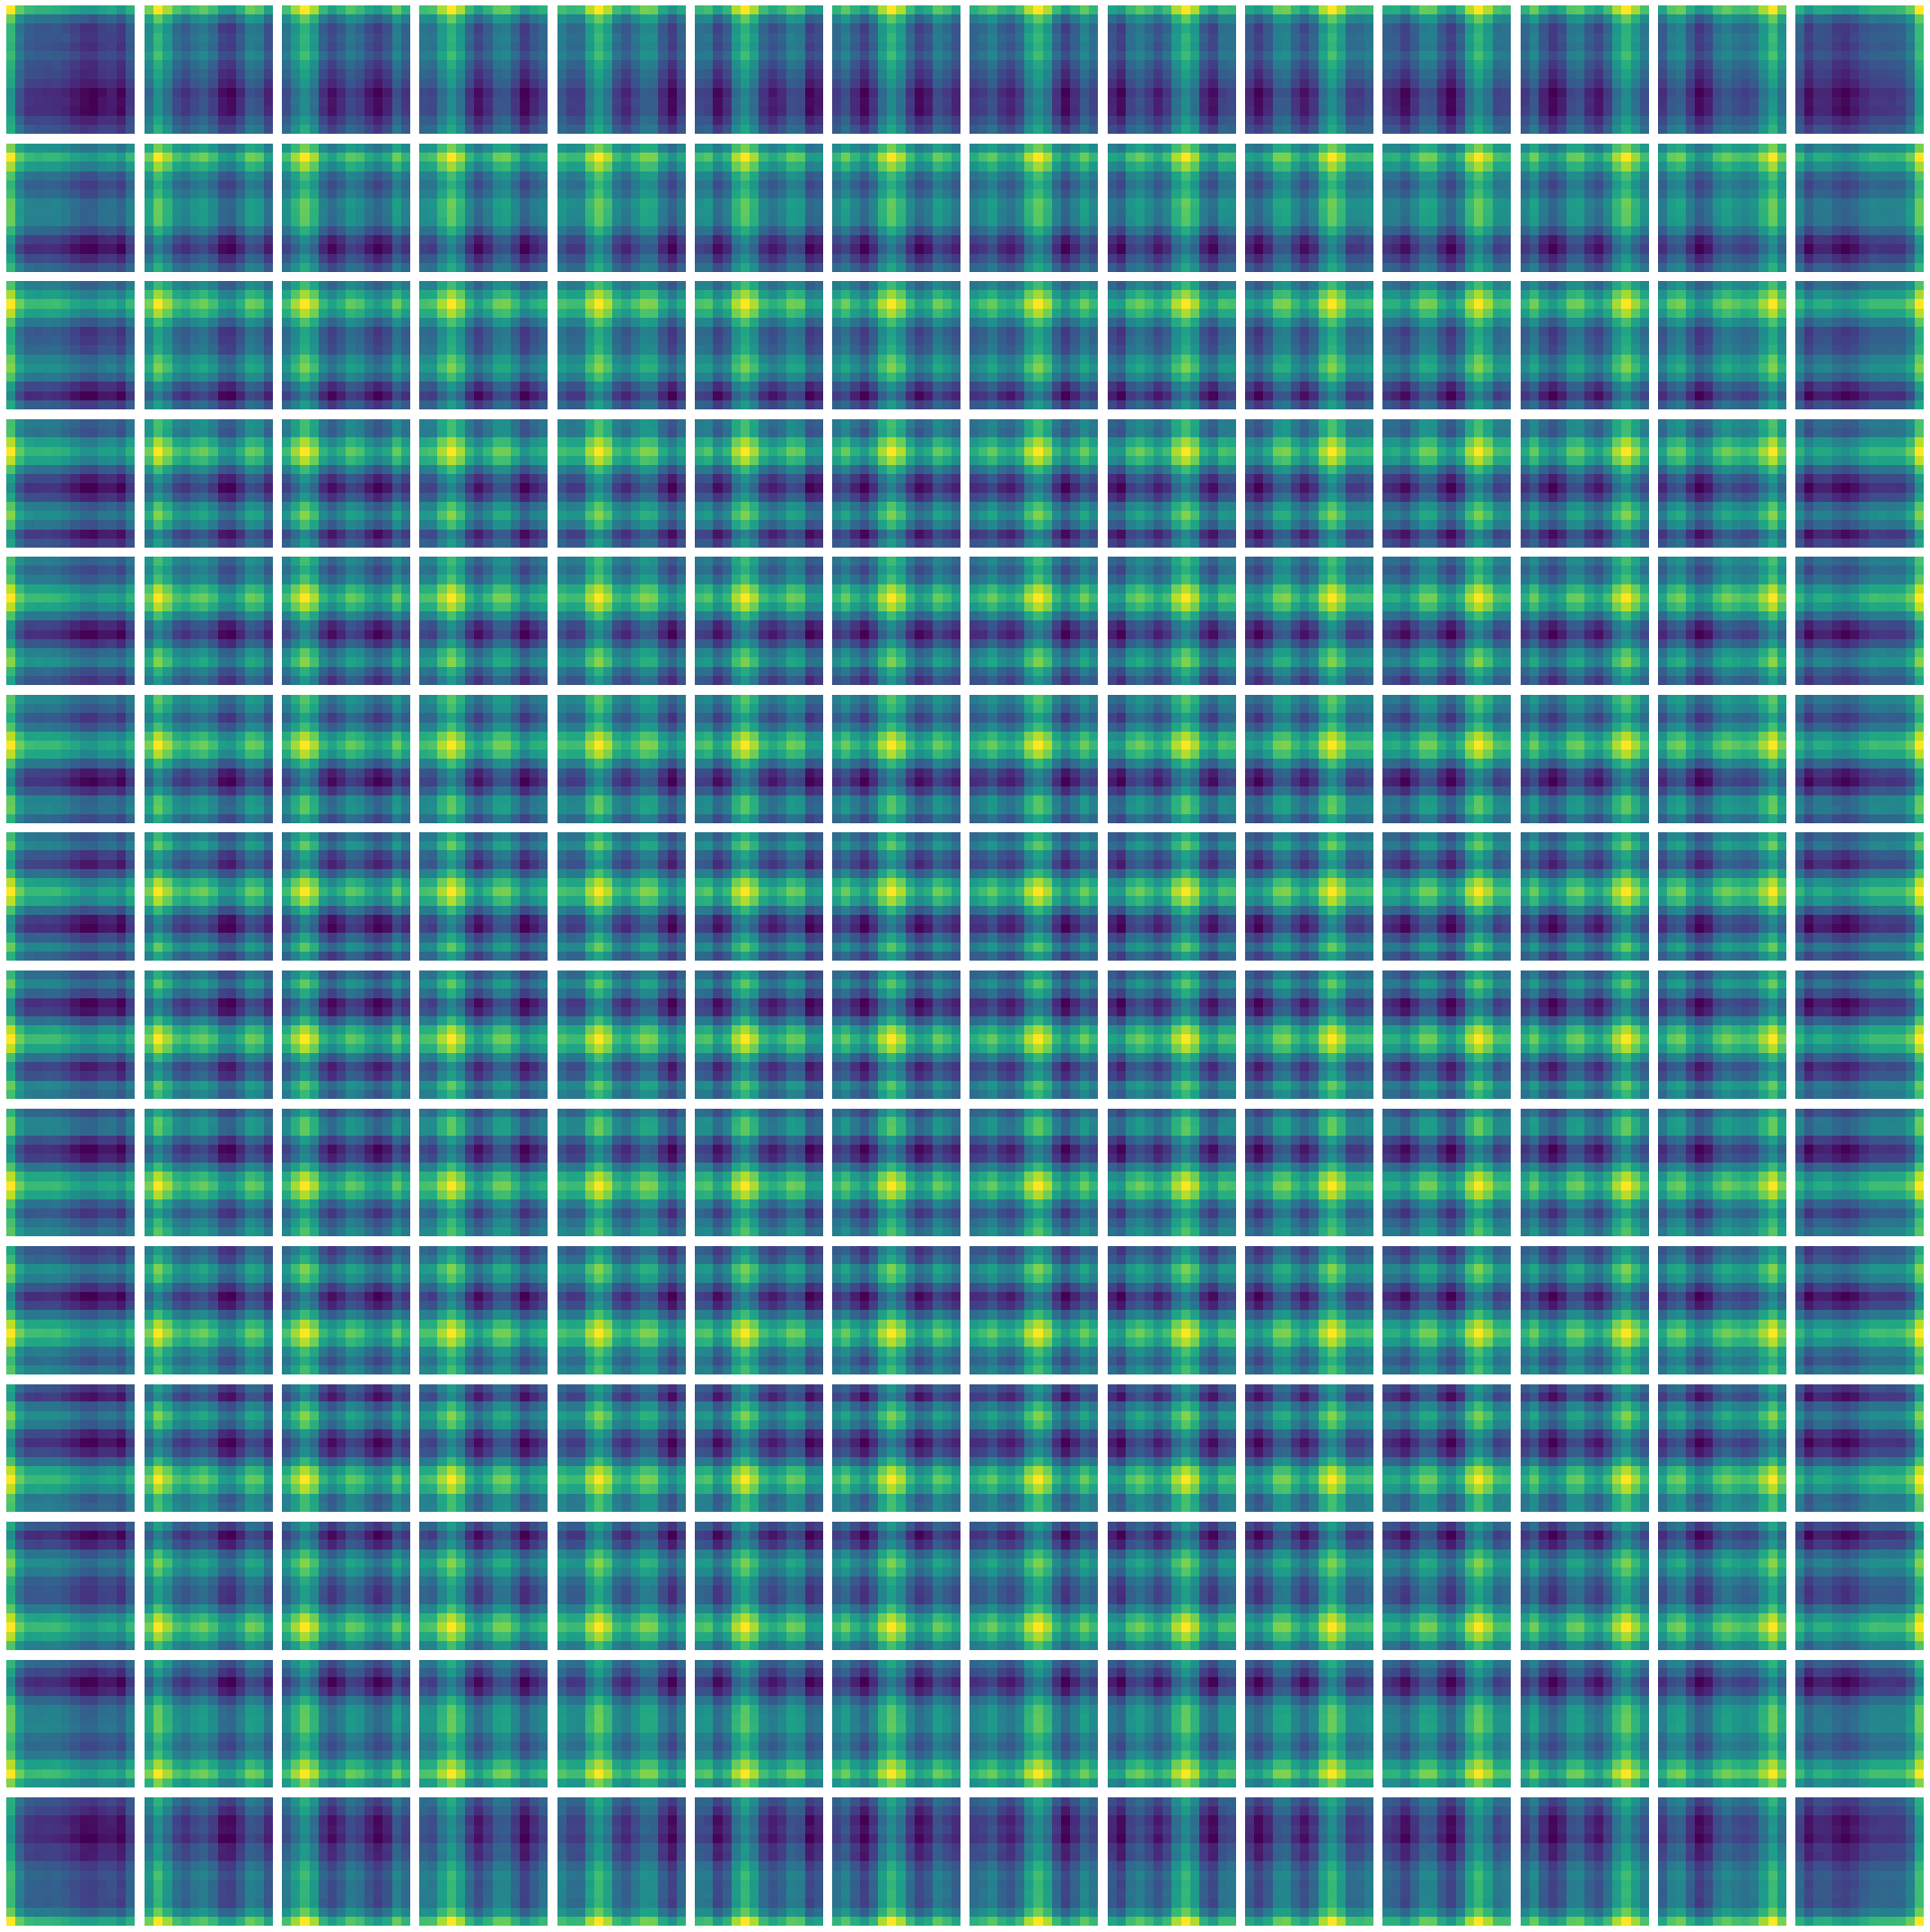

In [10]:
fig = plt.figure(figsize=(30,30))
axes = []
for i in range(196):
    s1 = similarity[i]
    smap = torch.reshape(s1, (14,14)).cpu().detach().numpy()
    axes.append(fig.add_subplot(14,14,i+1))
    im = plt.imshow(smap)
    plt.axis('off')

fig.tight_layout()
fig.savefig('p1-2.png')
    

In [11]:
s1 = similarity[0]
smap = torch.reshape(s1, (14,14)).cpu().detach().numpy()

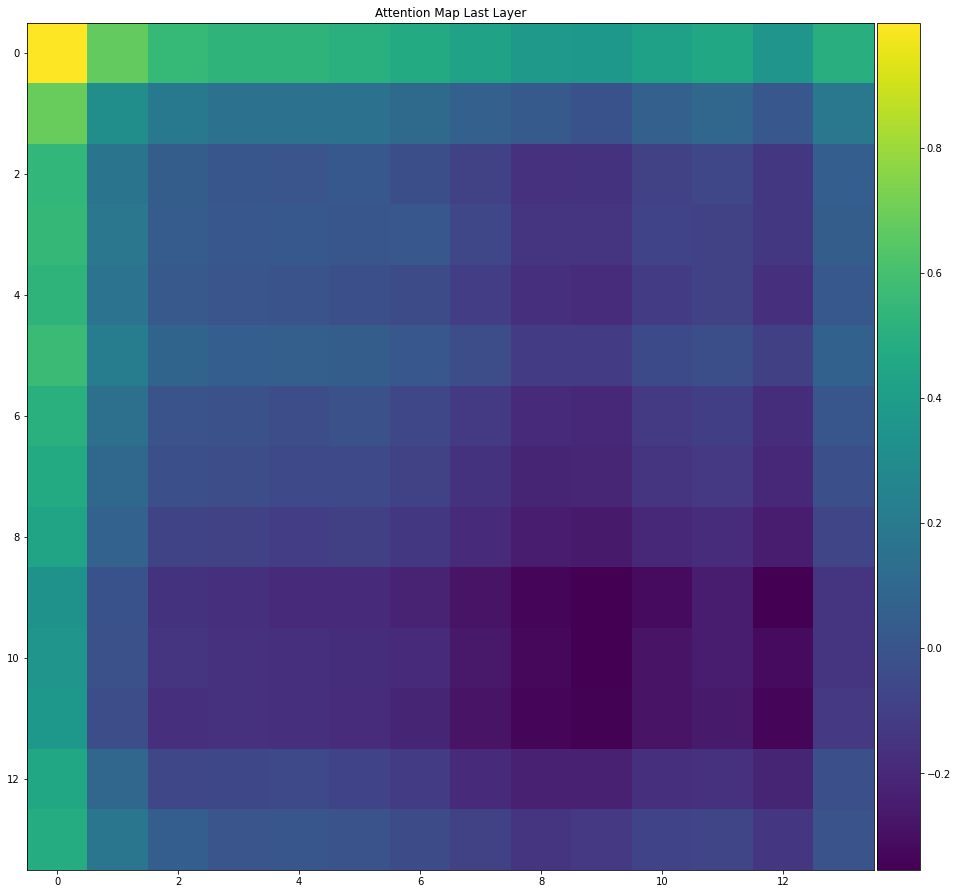

In [12]:
fig, ax= plt.subplots(figsize=(16, 16))
ax.set_title('Attention Map Last Layer')
im = ax.imshow(smap)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()